# Analyzing NYC High School Data

---

## 1. Introduction

The Scholastic Aptitude Test (SAT) is an exam that U.S. high school students take before applying to college. The total SAT score is out of 2,400 possible points, and consists of three sections with 800 possible points each. The scores are considered as a measure of the high school and school district quality.

The objective of this project is to determine the efficacy and fairness of standardized tests by **investigating the correlations between Scholastic Aptitude Test (SAT) scores and demographics in New York City**.

From our background research, we also learn that:
- New York City is made up of five boroughs, which are essentially distinct regions.
- New York City schools fall within several different school districts, each of which can contains dozens of schools.
- Our datasets include several different types of schools. Only high school students take the SAT, so we'll need to clean them so that we can focus on high schools only.
- Each school in New York City has a unique code called a `DBN` or district borough number.

We will be using the following datasets in this project:

| Filename | Dataset | Description |
| - | - | - |
| `ap_2010.csv` | [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) | Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject) |
| `class_size.csv` | [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) | Information on class size for each school |
| `demographics.csv` | [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) | Demographic information for each school |
| `graduation.csv` | [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) | The percentage of students who graduated, and other outcome information |
| `hs_directory.csv` |[High School Directory](https://data.cityofnewyork.us/Education/2014-2015-DOE-High-School-Directory/n3p6-zve2) | Directory of high schools in New York City |
| `sat_results.csv` | [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) | SAT scores for each high school in New York City |
| `survey_all.txt` | [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) | Surveys of parents, teachers, and students at each school in New York City |
| `survey_d75.txt` | [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) | Surveys of parents, teachers, and students at each school in New York City District 75 |

All of these datasets are interrelated and we'll need to combine them into a single dataset before we can find correlations.

---

## 2. Read and Explore the Data

Firstly, let's read each csv file into a pandas dataframe and store all the dataframes in a dictionary for exploration.

In [1]:
import pandas as pd
import numpy as np
import re

data_files = [
    'ap_2010.csv',
    'class_size.csv',
    'demographics.csv',
    'graduation.csv',
    'hs_directory.csv',
    'sat_results.csv'
]

data = {}

for f in data_files:
    d = pd.read_csv('schools/{0}'.format(f))
    data[f.replace('.csv', '')] = d
    
print('The csv files saved in the data dictionary are:')
print([_ for _ in data.keys()])

The csv files saved in the data dictionary are:
['ap_2010', 'class_size', 'demographics', 'graduation', 'hs_directory', 'sat_results']


We are mainly interested in the SAT scores dataset, which corresponds to the dictionary key `sat_results`. This dataset contains the SAT scores for each high school in New York City. Let's explore it to select useful values for us to correlate with information from other datasets.

In [2]:
print(f"There are {len(data['sat_results'])} rows in the sat_results dataframe.")
print(f"There are {len(data['sat_results']['SCHOOL NAME'].unique())} schools in the sat_results dataframe.")
print(f"There are {len(data['sat_results']['DBN'].unique())} DBN values in the sat_results dataframe.")

print('The first 5 rows in sat_results dataset are:')
data['sat_results'].head()

There are 478 rows in the sat_results dataframe.
There are 478 schools in the sat_results dataframe.
There are 478 DBN values in the sat_results dataframe.
The first 5 rows in sat_results dataset are:


,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


- The DBN appears to be a unique ID for each school.
- There's only a single row for each high school, so each `DBN` is unique in the SAT data.
- We can tell from the first few rows of names that we only have data about high schools.
- We may eventually want to combine the three columns that contain SAT scores (`SAT Critical Reading Avg. Score`, `SAT Math Avg. Score`, `SAT Writing Avg. Score`) into a single column to make the scores easier to analyze.

Now, we will explore the remaining datasets to gain insights on how to combine them.

In [3]:
for key, rows in data.items():
    print(f'The first 5 rows in {key} dataset are:')
    print(rows.head())
    print('\n')

The first 5 rows in ap_2010 dataset are:
      DBN                             SchoolName AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.              39   
1  01M450                 EAST SIDE COMMUNITY HS              19   
2  01M515                    LOWER EASTSIDE PREP              24   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH             255   
4  02M296  High School of Hospitality Management               s   

  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                49                                   10  
1                21                                    s  
2                26                                   24  
3               377                                  191  
4                 s                                    s  


The first 5 rows in class_size dataset are:
   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED

- Each dataset appears to either have a `DBN` column or the information we need to create one. That means we can use a `DBN` column to combine the datasets.
- Some fields look interesting for mapping, particularly `Location 1` in `hs_directory`, which contains coordinates inside a larger string.
- Some of the datasets appear to contain multiple rows with duplicate `DBN` values for each school. We need to pre-process this to ensure that the `DBN` values are unique within each dataset.

Now, let's read in and explore the text files too.

In [4]:
# Read text files
all_survey = pd.read_csv('schools/survey_all.txt', delimiter = '\t', encoding = 'windows-1252')
d75_survey = pd.read_csv('schools/survey_d75.txt', delimiter = '\t', encoding = 'windows-1252')

# Combine text files in a dataframe
survey = pd.concat([all_survey, d75_survey], axis = 0)

print('The first 5 rows in survey dataset are:')
survey.head()

The first 5 rows in survey dataset are:


,dbn,bn,schoolname,d75,studentssurveyed,highschool,schooltype,rr_s,rr_t,rr_p,...,s_q14_2,s_q14_3,s_q14_4,s_q14_5,s_q14_6,s_q14_7,s_q14_8,s_q14_9,s_q14_10,s_q14_11
0,01M015,M015,P.S. 015 Roberto Clemente,0,No,0.0,Elementary School,NaN,88,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01M019,M019,P.S. 019 Asher Levy,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01M020,M020,P.S. 020 Anna Silver,0,No,0.0,Elementary School,NaN,88,73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01M034,M034,P.S. 034 Franklin D. Roosevelt,0,Yes,0.0,Elementary / Middle School,89.0,73,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M063,M063,P.S. 063 William McKinley,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's rename the `dbn` column to uppercase and only retain the columns with useful information for analysis, before adding the dataframe to the dictionary.

In [5]:
# Copy DBN values in new column with uppercase name
survey['DBN'] = survey['dbn']

# Filter out unnecessary fields
survey_fields = [
    'DBN', 
    'rr_s', 
    'rr_t', 
    'rr_p', 
    'N_s', 
    'N_t', 
    'N_p', 
    'saf_p_11', 
    'com_p_11', 
    'eng_p_11', 
    'aca_p_11', 
    'saf_t_11', 
    'com_t_11', 
    'eng_t_11',
    'aca_t_11', 
    'saf_s_11', 
    'com_s_11', 
    'eng_s_11', 
    'aca_s_11', 
    'saf_tot_11', 
    'com_tot_11', 
    'eng_tot_11', 
    'aca_tot_11',
]
survey = survey.loc[:,survey_fields]

# Add survey dataframe to dictionary
data['survey'] = survey

# Print first 5 rows of survey data
print('The first 5 rows in survey dataset are now:')
data['survey']

The first 5 rows in survey dataset are now:


,DBN,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,...,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,01M015,NaN,88,60,NaN,22.0,90.0,8.5,7.6,7.5,...,7.6,7.9,NaN,NaN,NaN,NaN,8.0,7.7,7.5,7.9
1,01M019,NaN,100,60,NaN,34.0,161.0,8.4,7.6,7.6,...,8.9,9.1,NaN,NaN,NaN,NaN,8.5,8.1,8.2,8.4
2,01M020,NaN,88,73,NaN,42.0,367.0,8.9,8.3,8.3,...,6.8,7.5,NaN,NaN,NaN,NaN,8.2,7.3,7.5,8.0
3,01M034,89.0,73,50,145.0,29.0,151.0,8.8,8.2,8.0,...,6.8,7.8,6.2,5.9,6.5,7.4,7.3,6.7,7.1,7.9
4,01M063,NaN,100,60,NaN,23.0,90.0,8.7,7.9,8.1,...,7.8,8.1,NaN,NaN,NaN,NaN,8.5,7.6,7.9,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,75X352,90.0,58,48,38.0,46.0,160.0,8.9,8.3,7.9,...,5.7,5.8,6.8,6.0,7.8,7.6,7.4,6.6,7.1,7.2
52,75X721,84.0,90,48,237.0,82.0,239.0,8.6,7.6,7.5,...,6.7,7.0,7.8,7.2,7.8,7.9,8.0,7.1,7.3,7.6
53,75X723,77.0,74,20,103.0,69.0,74.0,8.4,7.8,7.8,...,6.7,7.6,6.7,7.2,7.7,7.7,7.6,7.4,7.4,7.7
54,75X754,63.0,93,22,336.0,82.0,124.0,8.3,7.5,7.5,...,6.6,7.1,6.8,6.6,7.6,7.7,7.2,6.9,7.3,7.5


---

## 3. Clean the Data

**a. Add DBN columns**

When exploring the datasets, we noticed that only `class_size` does not have `DBN` column. However, the `DBN` (e.g. 01M015) is just a padded combination of the `CSD` (e.g. 1) and `SCHOOL CODE` (e.g. M015) columns. 

In [6]:
print('The CSD values in class_size are:')
print(data['class_size']['CSD'].unique())

print('The SCHOOL CODE values in class_size are:')
print(data['class_size']['SCHOOL CODE'].unique())

print('Sample DBN values from another dataset:')
print(data['sat_results']['DBN'].unique()[:5])

The CSD values in class_size are:
[ 1  2 21 27  6  3  5  7  4  8  9 10 11 12 13 14 15 16 17 19 18 20 22 23
 24 25 26 28 29 30 31 32]
The SCHOOL CODE values in class_size are:
['M015' 'M019' 'M020' ... 'K554' 'K556' 'K564']
Sample DBN values from another dataset:
['01M292' '01M448' '01M450' '01M458' '01M509']


We will use this to create the `DBN` column.

In addition, `hs_directory` has a `dbn` column. We will copy the values into a new column named `DBN` with upper case instead.

In [7]:
# DBN column for hs_directory
data['hs_directory']['DBN'] = data['hs_directory']['dbn']

def pad_csd(num):
    string_representation = str(num)
    
    if len(string_representation) > 1:
        return string_representation
    else: 
        return '0' + string_representation # pad single digit number with 0 in front
    
# DBN column for class_size
data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(pad_csd)
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']

print('The DBN values in class_size are:')
print(data['class_size']['DBN'].unique())

The DBN values in class_size are:
['01M015' '01M019' '01M020' ... '32K554' '32K556' '32K564']


**b. Convert columns to numeric**

We notice below that the SAT scores (`SAT Math Avg. Score`, `SAT Critical Reading Avg. Score`, `SAT Writing Avg. Score`) in `sat_results` are stored as object data types.

In [8]:
data['sat_results'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   DBN                              478 non-null    object
 1   SCHOOL NAME                      478 non-null    object
 2   Num of SAT Test Takers           478 non-null    object
 3   SAT Critical Reading Avg. Score  478 non-null    object
 4   SAT Math Avg. Score              478 non-null    object
 5   SAT Writing Avg. Score           478 non-null    object
dtypes: object(6)
memory usage: 22.5+ KB


Let's convert them to numeric data types and add them together to determine the total SAT scores.

In [9]:
# Convert SAT scores to numeric
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data['sat_results'][c] = pd.to_numeric(data['sat_results'][c], errors = 'coerce') # set invalid parsing as NaN

# Compute total SAT score
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

# Confirm total SAT scores are between 0 to 2400
total_sat_unique = data['sat_results']['sat_score'].unique()
print(f'The total SAT scores in sat_results range from {min(total_sat_unique)} to {max(total_sat_unique)}.')

The total SAT scores in sat_results range from 887.0 to 2096.0.


Next, we will parse the latitude and longitude coordinates for each school from `Location 1` in `hs_directory`. This enables us to map the schools and uncover any geographic patterns in the data.

In [10]:
def find_lat(loc):
    coords = re.findall('\(.+, .+\)', loc) # extract lat and lon
    lat = coords[0].split(',')[0].replace('(', '') # select lat
    return lat

def find_lon(loc):
    coords = re.findall('\(.+, .+\)', loc) # extract lat and lon
    lon = coords[0].split(',')[1].replace(')', '').strip() # select lon
    return lon

# Create new columns for lat and lon
data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(find_lat)
data['hs_directory']['lon'] = data['hs_directory']['Location 1'].apply(find_lon)

# Convert to numeric
data['hs_directory']['lat'] = pd.to_numeric(data['hs_directory']['lat'], errors = 'coerce')
data['hs_directory']['lon'] = pd.to_numeric(data['hs_directory']['lon'], errors = 'coerce')

# Verify lat and lon in first few columns 
data['hs_directory'][['Location 1', 'lat', 'lon']].head()

,Location 1,lat,lon
0,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...",40.670299,-73.961648
1,"1110 Boston Road\nBronx, NY 10456\n(40.8276026...",40.827603,-73.904475
2,"1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...",40.842414,-73.916162
3,"411 Pearl Street\nNew York, NY 10038\n(40.7106...",40.710679,-74.000807
4,"160-20 Goethals Avenue\nJamaica, NY 11432\n(40...",40.718810,-73.806500


**c. Condense `ap_2010` dataset**

Previously, we observed that `sat_results` has unique `DBN` values for every high school in New York City.

However, some of the other datasets have multiple rows with duplicate `DBN` values.

In [11]:
print('The following datasets contain duplicate DBN values:')

for key, rows in data.items():
    if len(rows) != len(rows['DBN'].unique()): # compare number of rows and number of unique DBN values
        print(key)

The following datasets contain duplicate DBN values:
ap_2010
class_size
demographics
graduation


Let's begin from the `ap_2010` dataframe. We notice that there are only two rows with duplicate `DBN` values to resolve.

In [12]:
data['ap_2010'][data['ap_2010'].duplicated(subset = 'DBN', keep = False)]

,DBN,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5
51,04M610,THE YOUNG WOMEN'S LEADERSHIP SCHOOL OF EAST HA...,41,55,29
52,04M610,YOUNG WOMEN'S LEADERSHIP SCH,s,s,s


We will drop row 52 since it appears to be an erroneous copy of row 51.

In [13]:
# Drop duplicates except for first occurrence
data['ap_2010'].drop_duplicates(subset = 'DBN', inplace = True)

# Verify that correct row was removed
data['ap_2010'][data['ap_2010']['DBN'] == '04M610']

,DBN,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5
51,04M610,THE YOUNG WOMEN'S LEADERSHIP SCHOOL OF EAST HA...,41,55,29


**d. Condense `class_size` dataset**

We will take a look at the first few rows of `class_size`.

In [14]:
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


The first few rows all pertain to the same school, which is why the `DBN` appears more than once. It seems that each school has multiple values for `GRADE `, `PROGRAM TYPE`, `CORE SUBJECT (MS CORE and 9-12 ONLY)` and `CORE COURSE (MS CORE and 9-12 ONLY)`.

Let's look at the unique values for each of these columns.

In [15]:
for col in ['GRADE ', 'PROGRAM TYPE', 'CORE SUBJECT (MS CORE and 9-12 ONLY)', 'CORE COURSE (MS CORE and 9-12 ONLY)']:
    print(f"{col}: {data['class_size'][col].unique()} \n")
    
print('Program Type: Percentage')
print(data['class_size']['PROGRAM TYPE'].value_counts(normalize = True) * 100)

GRADE : ['0K' '01' '02' '03' '04' '05' '0K-09' nan '06' '07' '08' 'MS Core'
 '09-12' '09'] 

PROGRAM TYPE: ['GEN ED' 'CTT' 'SPEC ED' nan 'G&T'] 

CORE SUBJECT (MS CORE and 9-12 ONLY): ['-' nan 'ENGLISH' 'MATH' 'SCIENCE' 'SOCIAL STUDIES'] 

CORE COURSE (MS CORE and 9-12 ONLY): ['-' nan 'MS English Core' 'MS Math Core' 'MS Science Core'
 'MS Social Studies Core' 'Global History & Geography'
 'Integrated Algebra' 'Living Environment' 'Participation in Government'
 'US History & Government' 'English 9' 'English 10' 'English 11'
 'English 12' 'Geometry' 'Other Math' 'Earth Science' 'Chemistry'
 'Physics' 'Other Science' 'Other English' 'Trigonometry' 'Math A'
 'Economics' 'Other Social Studies' 'Math B'] 

Program Type: Percentage
GEN ED     55.670379
CTT        28.552838
SPEC ED    13.981705
G&T         1.795078
Name: PROGRAM TYPE, dtype: float64


- Since we're dealing with high schools, we will only select data that correspond to grades 9-12.
- Although each school can have multiple program types, we will only use `GEN ED` rows as this is the largest categry.
- `CORE SUBJECT (MS CORE and 9-12 ONLY)` and `CORE COURSE (MS CORE and 9-12 ONLY)` pertain to different class subjects, and we will take the average across every single class for each school.

In [16]:
class_size = data['class_size']

# Filter by grade and program type
class_size = class_size[class_size['GRADE '] == '09-12']
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']

# Aggregate by DBN and compute mean
class_size = class_size.groupby('DBN').agg(np.mean)
class_size.reset_index(inplace=True)

data['class_size'] = class_size

# Verify that DBN values are now unique
print(f"There are {len(data['class_size'])} rows in class_size.")
print(f"There are {len(data['class_size']['DBN'].unique())} unique DBN values in class_size.")

# Inspect first few rows
data['class_size'].head()

There are 583 rows in class_size.
There are 583 unique DBN values in class_size.


,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.0000,4.000000,22.564286,18.50,26.571429,NaN
1,01M332,1,46.0000,2.000000,22.000000,21.00,23.500000,NaN
2,01M378,1,33.0000,1.000000,33.000000,33.00,33.000000,NaN
3,01M448,1,105.6875,4.750000,22.231250,18.25,27.062500,NaN
4,01M450,1,57.6000,2.733333,21.200000,19.40,22.866667,NaN


**e. Condense `demographics` dataset**

Let's display the first few rows of this dataset.

In [17]:
data['demographics'].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


For this case, there appears to be multiple rows for each `DBN` with different `schoolyear` values. We only want to select rows where schoolyear is `20112012`. This will give us the most recent year of data, and also match our SAT results data.

In [18]:
data['demographics'] = data['demographics'][data['demographics']['schoolyear'] == 20112012]

# Verify that DBN values are now unique
print(f"There are {len(data['demographics'])} rows in demographics.")
print(f"There are {len(data['demographics']['DBN'].unique())} unique DBN values in demographics.")

# Inspect first few rows
data['demographics'].head()

There are 1509 rows in demographics.
There are 1509 unique DBN values in demographics.


,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,54,...,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
20,01M020,PS 020 ANNA SILVER,20112012,NaN,92.5,626,52,102,121,87,...,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3
27,01M034,PS 034 FRANKLIN D ROOSEVELT,20112012,NaN,99.7,401,14,34,38,36,...,90,22.4,275,68.6,8,2.0,204.0,50.9,197.0,49.1
35,01M063,PS 063 WILLIAM MCKINLEY,20112012,NaN,78.9,176,18,20,30,21,...,41,23.3,110,62.5,15,8.5,97.0,55.1,79.0,44.9


**f. Condense `graduation` dataset**

The last dataset to condense is `graduation`, here are the first few rows:

In [19]:
data['graduation'].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,s,s,s,s,...,s,s,s,s,s,s,s,s,s,s
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3%,17,30.9%,45.9%,...,17,30.9%,45.9%,20,36.4%,54.1%,15,27.3%,3,5.5%
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2%,27,42.2%,62.8%,...,27,42.2%,62.8%,16,25%,37.200000000000003%,9,14.1%,9,14.1%
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4%,37,47.4%,84.1%,...,37,47.4%,84.1%,7,9%,15.9%,15,19.2%,11,14.1%


The `Demographic` and `Cohort` columns prevent `DBN` from being unique. We will inspect the unique values from these columns.

In [20]:
for col in ['Demographic', 'Cohort']:
    print(f'The unique values in {col} are:')
    print(data['graduation'][col].unique())

The unique values in Demographic are:
['Total Cohort' 'Male' 'English Language Learners'
 'English Proficient Students' 'Special Education Students'
 'General Education Students' 'Asian' 'Black' 'Hispanic' 'White' 'Female']
The unique values in Cohort are:
['2003' '2004' '2005' '2006' '2006 Aug' '2001' '2002']


- `Demographic` refers to a specific demographic group, and we will select data from the full cohort (i.e. Total Cohort).
- `Cohort` refers to the year the data represents, so we will pick data from the most recent 2006 cohort.

In [21]:
data['graduation'] = data['graduation'][data['graduation']['Cohort'] == '2006']
data['graduation'] = data['graduation'][data['graduation']['Demographic'] == 'Total Cohort']

# Verify that DBN values are now unique
print(f"There are {len(data['graduation'])} rows in graduation.")
print(f"There are {len(data['graduation']['DBN'].unique())} unique DBN values in graduation.")

# Inspect first few rows
data['graduation'].head()

There are 405 rows in graduation.
There are 405 unique DBN values in graduation.


,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7%,42,33.9%,79.2%,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
17,Total Cohort,01M450,EAST SIDE COMMUNITY SCHOOL,2006,90,70,77.8%,67,74.400000000000006%,95.7%,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
24,Total Cohort,01M509,MARTA VALLE HIGH SCHOOL,2006,84,47,56%,40,47.6%,85.1%,...,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%
31,Total Cohort,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHO,2006,193,105,54.4%,91,47.2%,86.7%,...,22,11.4%,21%,14,7.3%,13.3%,53,27.5%,35,18.100000000000001%


**g. Convert AP scores to numeric**

We also need to  convert the Advanced Placement (AP) test scores from strings to numeric values.

AP exams have a 1 to 5 scale; 3 or higher is a passing score. Many high school students take AP exams, particularly those who attend academically challenging institutions. AP exams are rarer in schools that lack funding or academic rigor.

It will be interesting to find out whether AP exam scores are correlated with SAT scores across high schools. To determine this, we'll need to convert the AP exam scores in the ap_2010 data set to numeric values first.

In [22]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data['ap_2010'][col] = pd.to_numeric(data['ap_2010'][col], errors = 'coerce')
    print(f"The {col} column has been converted to {data['ap_2010'][col].dtype}.")

The AP Test Takers  column has been converted to float64.
The Total Exams Taken column has been converted to float64.
The Number of Exams with scores 3 4 or 5 column has been converted to float64.


**h.  Combine the datasets**

We'll now use the DBN column to identify matching rows across datasets, and merge two datasets at a time. There may be `DBN` values that exist in one dataset but not in another because:
- the data sets are from different years
- each data set may have inconsistencies in terms of how it was gathered
- human error in data collection and entry

Since this project is concerned with determining demographic factors that correlate with SAT score, we'll want to preserve as many rows as possible from `sat_results` while minimizing null values.

Both the `ap_2010` and the `graduation` datasets have many missing `DBN` values, so we'll use a left join when we merge the `sat_results` data set with them. This will help us avoid losing too many rows of useful data. Since we're using a left join, our final dataframe will have all of the same `DBN` values as the original `sat_results` dataframe.

In [23]:
# Assign sat_results to new dataframe
combined = data['sat_results']

# Merge with left join
combined = combined.merge(data['ap_2010'], on = 'DBN', how = 'left')
combined = combined.merge(data['graduation'], on = 'DBN', how = 'left')

# Display dataframe shape and verify first few rows
print(f'The combined dataframe now has {combined.shape[0]} rows and {combined.shape[1]} columns. Here are the first few rows:')
combined.head()

The combined dataframe now has 478 rows and 33 columns. Here are the first few rows:


,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
3,01M458,FORSYTH SATELLITE ACADEMY,7,414.0,401.0,359.0,1174.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,NaN,NaN,NaN,...,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%


Now that we've performed the left joins, we still have to merge `class_size`, `demographics`, `survey` and `hs_directory` into `combined`. 

Since these files contain information that's more valuable to our analysis and also have fewer missing `DBN` values, we'll use the inner join type.

In [24]:
to_merge = ['class_size', 'demographics', 'survey', 'hs_directory']

for m in to_merge:
    combined = combined.merge(data[m], on = 'DBN', how = 'inner')

# Display dataframe shape and verify first few rows
print(f'The combined dataframe now has {combined.shape[0]} rows and {combined.shape[1]} columns. Here are the first few rows:')
combined.head()

The combined dataframe now has 362 rows and 159 columns. Here are the first few rows:


,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,Then to Manhattan students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.0,377.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426


After the inner joins, the number of rows in decreased from 478 to 362, because there are 116 `DBN` values in `sat_results` that were not in other datasets. We will not delve into these values as we are primarily interested in high-level correlations.

Now, we also have many columns will null (NaN values), due to missing data in some columns when performing left joins. We will proceed to:
- fill in the missing values with the overall average for each column
- for columns with all null values, we will replace them with zero value instead

In [25]:
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Verify first few rows
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to Manhattan students or residents,Then to New York City residents,0,0,0.0,0.0,0.0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0.0,0.0,0.0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0.0,0.0,0.0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0,0.0,0.0,0.0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0.0,0.0,0.0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426


**i. Add a school district column for mapping**

We now have a clean dataset for analysis. Mapping the statistics out on a school district level might also be an interesting way to analyze them. So let's add a column to the combined dataset that specifies the school district.

In [26]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

print('The unique school district values are:')
print([_ for _ in combined["school_dist"].unique()])

The unique school district values are:
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32']


---

## 4. Analyze the Data

**a. Correlations with `sat_score`**

Firstly, let's find any correlations between `sat_score` and the other columns in the combined dataset. This will help us determine which columns might be interesting to plot out or investigate further.

In [27]:
import matplotlib.pyplot as plt

# Compute r values
correlations = combined.corr()
correlations = correlations["sat_score"].sort_values()

# Positive r values
print('Columns that correlate positively with SAT score:')
print('Column:                                 r value')
print(correlations[correlations > 0].sort_values(ascending = False))

print('\n')

# Negative r values
print('Columns that correlate negatively with SAT score:')
print('Column:         r value')
print(correlations[correlations < 0])

Columns that correlate positively with SAT score:
Column:                                 r value
sat_score                               1.000000
SAT Writing Avg. Score                  0.987835
SAT Critical Reading Avg. Score         0.986821
SAT Math Avg. Score                     0.972664
white_per                               0.621986
asian_per                               0.571624
AP Test Takers                          0.523383
Total Exams Taken                       0.514572
asian_num                               0.476277
Number of Exams with scores 3 4 or 5    0.463458
white_num                               0.450429
N_s                                     0.424319
N_p                                     0.421948
total_students                          0.408762
NUMBER OF STUDENTS / SEATS FILLED       0.395932
female_num                              0.388672
AVERAGE CLASS SIZE                      0.380888
total_enrollment                        0.368810
NUMBER OF SECTIONS  

a. As expected, `SAT Critical Reading Avg. Score`, `SAT Math Avg. Score`, `SAT Writing Avg. Score` and `sat_score` are strongly correlated with `sat_score`.

b. `total_enrollment` has a strong positive correlation with `sat_score`. This is surprising because we expect smaller schools where students receive more attention to have higher scores. 

c. The percentage of English language learners at the school (`ell_percent`, `frl_percent`) has a strong negative correlation with SAT scores.

d. Teacher and student ratings of school safety (`saf_t_11` and `saf_s_11`) correlate with `sat_score`. Student ratings of school academic standards (`aca_s_11`) correlate with `sat_score`, but this does not hold for ratings from teachers and parents (`aca_p_11` and `aca_t_11`).

e. There is significant racial inequality in SAT scores (`white_per`, `asian_per`, `black_per`, `hispanic_per`).

f. Both the percentage of females (`female_per`) and number of females (`female_num`) at a school correlate positively with SAT score, whereas the number of males (`male_num`) correlate negatively. This could indicate that women do better on the SAT than men.

g. Other columns that are proxies for enrollment correlate similarly. These include `total_students`, `N_s`, `N_p`, `N_t`, `AP Test Takers`, `Total Exams Taken` and `NUMBER OF SECTIONS`.

h. The average class size (`AVERAGE CLASS SIZE`) correlate positively with SAT score. This is unexpected as a higher student-teacher probably means less attention for each student.

In the subsequent sub-sections, we will proceed to explore these relations in further detail.

**b. Relation between enrollment and SAT score**

Since enrollment seems to have such a strong correlation, let's make a scatter plot of `sat_score` against `total_enrollment`. Each point in the scatter plot represents a high school, so we'll be able to see if there are any interesting patterns.

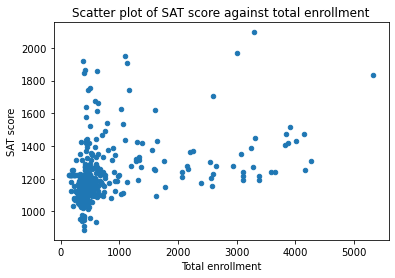

In [28]:
combined.plot.scatter('total_enrollment', 'sat_score')

plt.title('Scatter plot of SAT score against total enrollment')
plt.xlabel('Total enrollment')
plt.ylabel('SAT score')

plt.show()

From the scatter plot, there does not appear to be a strong correlation between `total_enrollment` and `sat_score`. 

However, there's an interesting cluster of points at the bottom left where `total_enrollment` and `sat_score` are both low. This cluster may be the reason behind the high r value. We will extract the names of schools in this cluster for further investigation.

In [29]:
low_enrollment = combined[(combined['total_enrollment'] < 1000) & (combined['sat_score'] < 1000)]
print('The schools with low total enrollment (1000) and low SAT scores (< 1000) are:')
print(low_enrollment['School Name'])

The schools with low total enrollment (1000) and low SAT scores (< 1000) are:
90       INTERNATIONAL COMMUNITY HIGH SCHOOL
124                                        0
125          BRONX INTERNATIONAL HIGH SCHOOL
138    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
140    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
175                                        0
178            HIGH SCHOOL OF WORLD CULTURES
187       BROOKLYN INTERNATIONAL HIGH SCHOOL
224    INTERNATIONAL HIGH SCHOOL AT PROSPECT
236               IT TAKES A VILLAGE ACADEMY
252                MULTICULTURAL HIGH SCHOOL
285    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object


After conducting some research, we realise that these schools have high percentages of English language learners. 

This indicates that it's actually `ell_percent` that correlates strongly with `sat_score`, rather than `total_enrollment`. 

**c. Relation between percentage of English language learners and SAT score**

To explore this relationship further, let's plot out `ell_percent` vs `sat_score`.

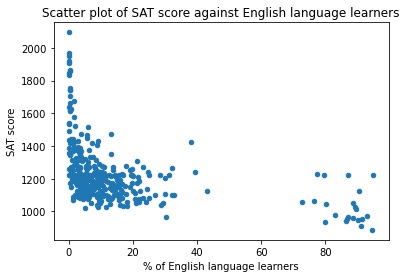

In [30]:
combined.plot.scatter('ell_percent', 'sat_score')

plt.title('Scatter plot of SAT score against English language learners')
plt.xlabel('% of English language learners')
plt.ylabel('SAT score')

plt.show()

We can ascertain from the plot that a school with higher percentage of English language learners is likely to have lower SAT scores. In fact, it seems like schools with average SAT score of above 1600 have no English language learners at all.

**d. Relation between safety scores and SAT score**

Previously, we also noticed that `saf_t_11` and `saf_s_11`, which measure how teachers and students perceive safety at school, correlated highly with sat_score. Let's make a scatter plot of `saf_s_11` with `sat_score` to visualise their correlation.

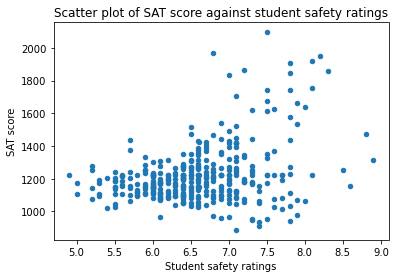

In [31]:
combined.plot.scatter('saf_s_11', 'sat_score')

plt.title('Scatter plot of SAT score against student safety ratings')
plt.xlabel('Student safety ratings')
plt.ylabel('SAT score')

plt.show()

There appears to be a positive correlation between student safety ratings and SAT scores. Schools with SAT scores above 1600 have student safety ratings of at least 6.5. Next, let's explore which borough has schools with higher average safety ratings.

In [32]:
boroughs = combined.groupby('boro').agg(np.mean)
print(boroughs[['saf_s_11', 'sat_score']])

               saf_s_11    sat_score
boro                                
Bronx          6.606550  1157.578392
Brooklyn       6.370755  1181.347079
Manhattan      6.823802  1277.757855
Queens         6.721875  1286.729042
Staten Island  6.530000  1382.500000


On average, schools in Manhattan and Queens have higher safety ratings and better SAT scores.

**e. Relation between racial percentages and SAT score**

These columns indicate the percentage of each race at a given school: `white_per`, `asian_per`, `black_per` and `hispanic_per`.

We can plot out the correlations between these columns and `sat_score`, to determine whether there are any racial differences in SAT performance.

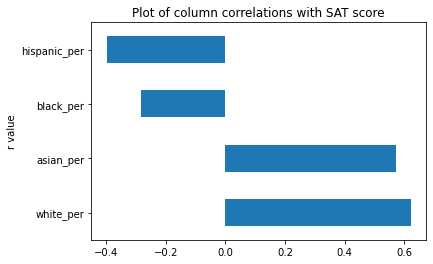

In [33]:
race = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

correlations[race].plot.barh(xlabel = 'r value', ylabel = 'Column',
                             title = 'Plot of column correlations with SAT score')

plt.show()

- The percentage of white or asian students at a school correlates positively with SAT score
- The percentage of black or hispanic students correlates negatively with SAT score

This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.

We will delve deeper into schools with low SAT scores and high `hispanic_per` values.

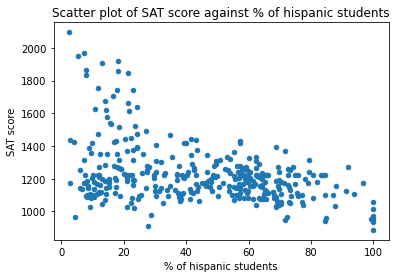

In [34]:
combined.plot.scatter('hispanic_per', 'sat_score')

plt.title('Scatter plot of SAT score against % of hispanic students')
plt.xlabel('% of hispanic students')
plt.ylabel('SAT score')

plt.show()

The scatter plot ascertains the negative correlation between the percentage of hispanic students and SAT score.

Let's extract and have a look at the names of schools with:
- `hispanic_per` greater than 95%
- `hispanic_per` less than 10% and average SAT 

In [35]:
print('Schools with hispanic_per > 95%')
combined[['boro', 'SCHOOL NAME']][combined['hispanic_per'] > 95]

Schools with hispanic_per > 95%


,boro,SCHOOL NAME
44,Manhattan,MANHATTAN BRIDGES HIGH SCHOOL
81,Manhattan,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
88,Manhattan,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
124,Bronx,ACADEMY FOR LANGUAGE AND TECHNOLOGY
140,Bronx,INTERNATIONAL SCHOOL FOR LIBERAL ARTS
175,Bronx,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
252,Brooklyn,MULTICULTURAL HIGH SCHOOL
285,Queens,PAN AMERICAN INTERNATIONAL HIGH SCHOOL


The schools listed above are mostly located in the Bronx or Manhatten boroughs and are primarily geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [36]:
# Research any schools with a hispanic_per less than 10% and an average SAT score greater than 1800.
print('Schools with hispanic_per < 10% and average SAT score > 1800')
combined[['boro', 'SCHOOL NAME']][(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]

Schools with hispanic_per < 10% and average SAT score > 1800


,boro,SCHOOL NAME
37,Manhattan,STUYVESANT HIGH SCHOOL
150,Bronx,BRONX HIGH SCHOOL OF SCIENCE
186,Brooklyn,BROOKLYN TECHNICAL HIGH SCHOOL
326,Queens,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
355,Staten Island,STATEN ISLAND TECHNICAL HIGH SCHOOL


Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low `hispanic_per`, but it does explain why their students tend to do better on the SAT, since they are students from all over New York City who did well on a standardized test.

**f. Relation between gender and SAT score**

The `male_per` and `female_per` columns indicate the percentage of each gender at a school. 

We can plot out the correlations between each column and `sat_score`.

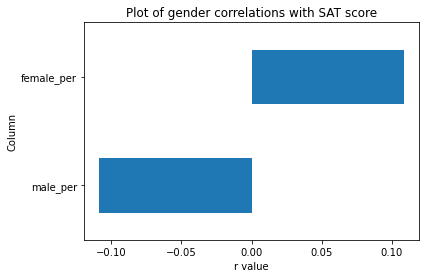

In [37]:
gender = ['male_per', 'female_per']
correlations[gender].plot.barh()

plt.title('Plot of gender correlations with SAT score')
plt.xlabel('r value')
plt.ylabel('Column')
plt.show()

It seems that:
- The percentage of female students has a minor positive correlation with SAT score.
- The percentage of male students has a minor negative correlation with SAT score.

Let's make a scatter plot of `sat_score` against `female_per` to confirm this.

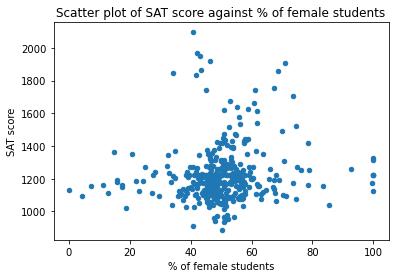

In [38]:
combined.plot.scatter('female_per', 'sat_score')

plt.title('Scatter plot of SAT score against % of female students')
plt.xlabel('% of female students')
plt.ylabel('SAT score')

plt.show()

Although there does not seem to be any real correlation on the scatter plot, schools with high SAT scores tend to have average `female_per` of around 40% to 70%. We will extract names of schools with a `female_per greater` than 60% and an average SAT score greater than 1700 for further research.

In [39]:
print('Schools with female_per < 60% and average SAT score > 1700')
combined[['boro', 'SCHOOL NAME']][(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]

Schools with female_per < 60% and average SAT score > 1700


,boro,SCHOOL NAME
5,Manhattan,BARD HIGH SCHOOL EARLY COLLEGE
26,Manhattan,ELEANOR ROOSEVELT HIGH SCHOOL
60,Manhattan,BEACON HIGH SCHOOL
61,Manhattan,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
301,Queens,TOWNSEND HARRIS HIGH SCHOOL


These schools appears to be very selective liberal arts schools that have high academic standards, and are mostly located in Manhatten.

**g. Relation between AP exams and SAT score**

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects. It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. 

Let's explore this relationship. Because `total_enrollment` is highly correlated with `sat_score`, we don't want to lead to biased results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

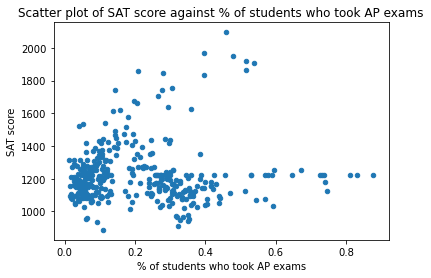

In [40]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

combined.plot.scatter('ap_per', 'sat_score')

plt.title('Scatter plot of SAT score against % of students who took AP exams')
plt.xlabel('% of students who took AP exams')
plt.ylabel('SAT score')

plt.show()

The positive correlation between `ap_per` and `sat_score` is not observed to be strong. There are schools with low SAT scores even though the percentage of AP test takers is high.

**h. Relation between average class size and SAT score**

Lastly, we'll visualise the relationship between `AVERAGE CLASS SIZE` and `sat_score`, to understand why this correlation has a positive r value.

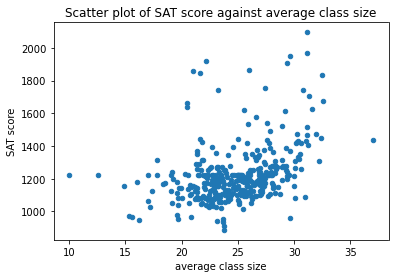

In [41]:
combined.plot.scatter('AVERAGE CLASS SIZE', 'sat_score')

plt.title('Scatter plot of SAT score against average class size')
plt.xlabel('average class size')
plt.ylabel('SAT score')

plt.show()

We can see that there is no real correlation between class size and SAT score, although schools with SAT scores of above 1600 have class sizes ranging from 20 to 33.

---

## 5. Conclusion

In conclusion, we observe that the SAT score:
- has a positive correlation with the percentage of English language learners, safety ratings and percentage of white or asian students,
- has a negative correlation with the percentage of black or hispanic students, and
- does not appear to have a strong correlation with school enrollment, gender proportion and average class size.